# Evaluating U-Net and simple single convoluation baseline models on SSI split data

So test set is 10% made up of wettest days +/- 5 days (stratified by season), validation set is the next 20%.

In [1]:
%load_ext autoreload

%autoreload 2

In [2]:
%reload_ext autoreload
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import yaml

from ml_downscaling_emulator.evaluation import open_test_set
from ml_downscaling_emulator.helpers import plots_at_ts
from ml_downscaling_emulator.utils import cp_model_rotated_pole
# dir2 = os.path.abspath('../../src/ml_downscaling_emulator/unet/unet')
# dir1 = os.path.dirname(dir2)
# if not dir1 in sys.path: sys.path.append(dir1)
# import unet
from ml_downscaling_emulator.unet import unet as unet
# weird hack as I moved the unet package foolishly
sys.modules['unet'] = unet

In [15]:
scale_factors = [2, 4, 8, 16, 27]
model_archs = ["u-net", "simple-conv"]
split_scheme = "ssi"
portions = ["test", "train"]

In [17]:
def plot_mean_diffs(models_mean_diffs, model_names):
    bias_vmin = min(*[diff.pr.min().values for diff in models_mean_diffs])
    bias_vmax = max(*[diff.pr.max().values for diff in models_mean_diffs])
    bias_vmin = min(bias_vmin, -bias_vmax)
    bias_vmax = max(bias_vmax, -bias_vmin)

    f, axes = plt.subplots(1, len(models_mean_diffs), figsize=(24, 8), subplot_kw={'projection': cp_model_rotated_pole})

    for i, model_mean_diff in enumerate(models_mean_diffs):
        ax = axes[i]
        ax.coastlines()
        model_mean_diff.pr.plot(ax = ax, x='grid_longitude', y='grid_latitude', transform=cp_model_rotated_pole, vmin=bias_vmin, vmax=bias_vmax, cmap='BrBG')
        ax.set_title(f"{model_names[i]} mean bias")

def compare_preds(models_preds, models_mean_diffs, test_set, model_names):
    for portion in ["test", "train"]:
        plot_mean_diffs([diff[portion] for diff in models_mean_diffs], [f"{model_name} on {portion} set" for model_name in model_names])

    # Plot example timestamp and residuals
    timestamp = test_set.time[0].values
    raw_pr = [test_set.target_pr]+[pred.pr for pred in models_preds]
    
    plots_at_ts(raw_pr, timestamp, titles=["Target pr from CPM"]+model_names)#, vmax=vmax)
    residual_pr = [pred - test_set.target_pr for pred in raw_pr]
    res_vmin = min([ds.sel(time=timestamp).min().values for ds in residual_pr])
    res_vmax = max([ds.sel(time=timestamp).max().values for ds in residual_pr])
    plots_at_ts(residual_pr, timestamp, titles=[f"Residual of {model_name} - Target pr" for model_name in ["Target pr from CPM"]+model_names], vmin=res_vmin, vmax=res_vmax, cmap="BrBG")#, vmax=vmax)

    # Plot predicted rainfall values against hi-res ones
    f, axes = plt.subplots(1, len(models_preds), figsize=(24, 8))

    tr = min(test_set.target_pr.values.max(), *[model_preds.pr.max().values for model_preds in models_preds])
    for i, model_preds in enumerate(models_preds):
        ax = axes[i]
        ax.scatter(x=test_set.target_pr, y=model_preds.pr, alpha=0.1, c='b')
        ax.plot([0, tr], [0, tr], linewidth=1, color='green')
        ax.set_title(f"{model_names[i]} predicted pr vs hi-res target pr")

    plt.figure()
    for model_preds in models_preds:
        model_preds.sum(dim=["grid_longitude", "grid_latitude"]).pr.plot.hist(alpha=0.1, log=True, density=True)
    test_set.sum(dim=["grid_longitude", "grid_latitude"]).target_pr.plot.hist(alpha=0.1, log=True, density=True)


In [18]:
test_sets = {sf: open_test_set(f"../../../../derived_data/nc-datasets/2.2km-coarsened-{sf}x_london_pr_{split_scheme}/test.nc") for sf in scale_factors}

In [19]:
data = {"pred": {}, "bias": {}}

for arch in model_archs:
    data["pred"][arch] = {}
    data["bias"][arch] = {}
    for sf in scale_factors:
        dataset = f"2.2km-coarsened-{sf}x_london_pr_{split_scheme}"
        
        pred_path = os.path.join(os.environ["DERIVED_DATA"], "evaluation", dataset, arch, "test", "predictions.nc")
        
        data["pred"][arch][sf] = xr.open_dataset(pred_path)
        
        data["bias"][arch][sf] = {}
        for portion in portions:
            bias_path = os.path.join(os.environ["DERIVED_DATA"], "evaluation", dataset, arch, portion, "mean-diff.nc")
            data["bias"][arch][sf][portion] = xr.open_dataset(bias_path)

## 2x coarsened

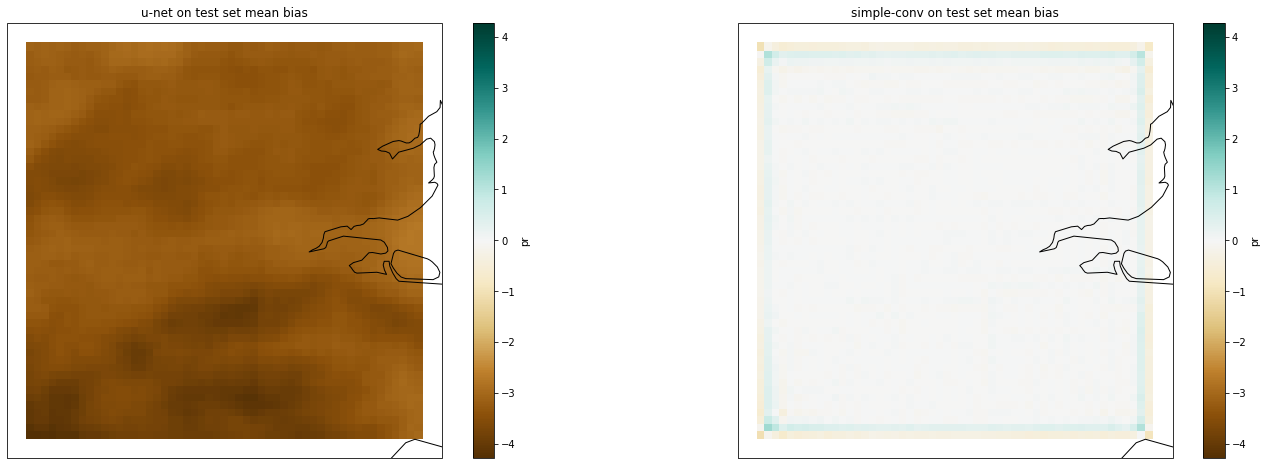

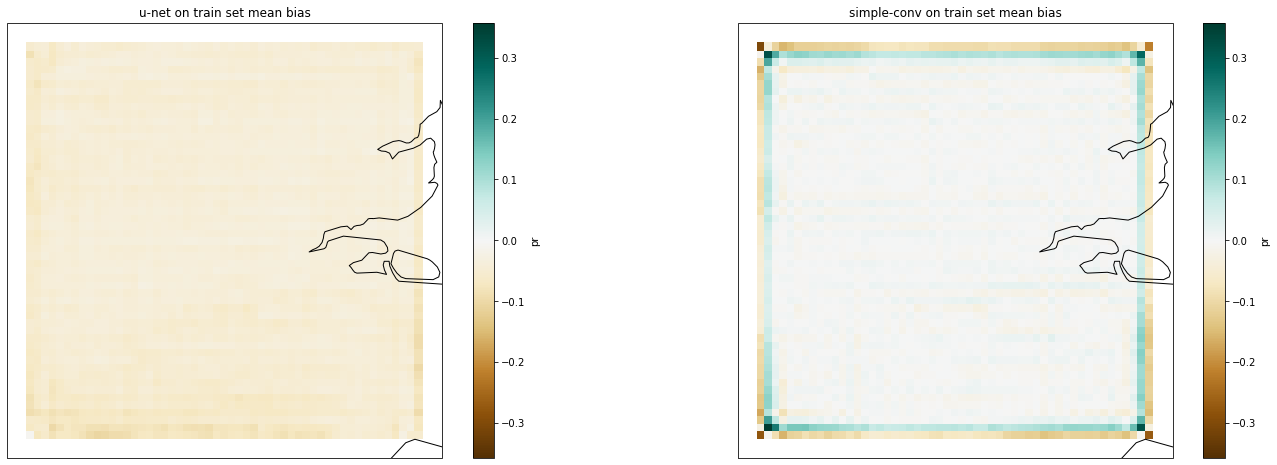

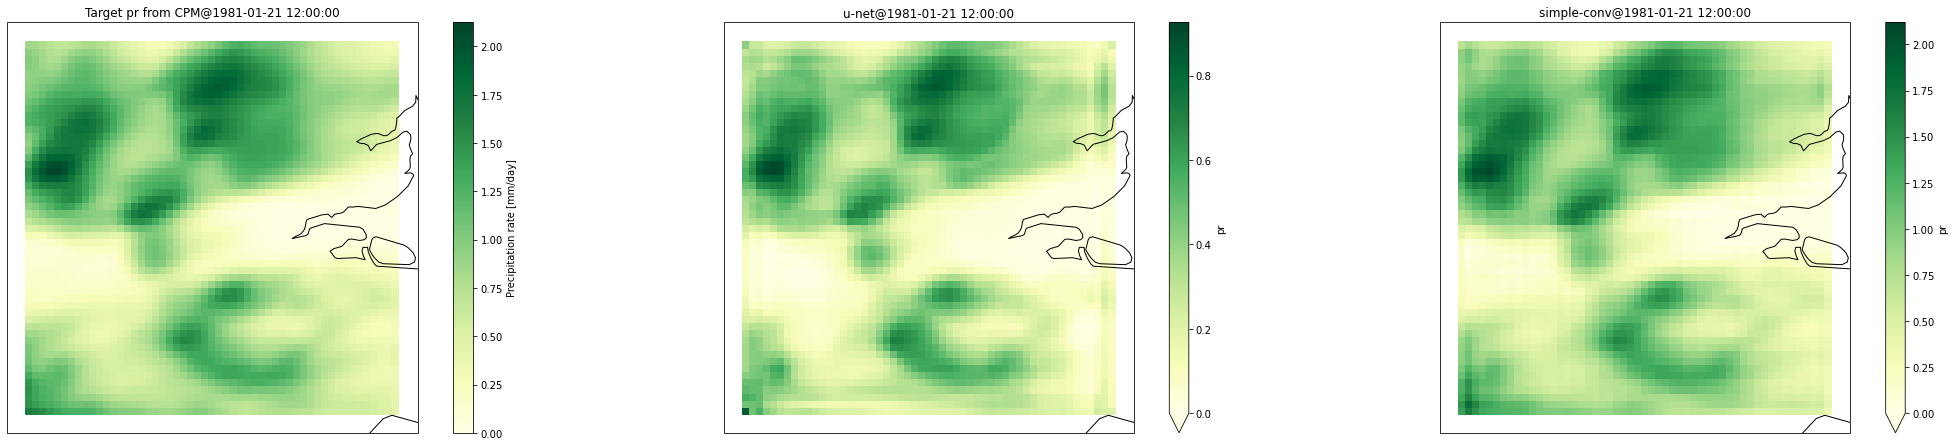

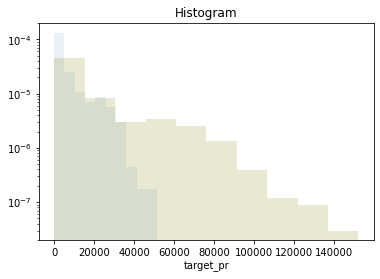

In [20]:
sf = 2
compare_preds([data["pred"][arch][sf] for arch in model_archs], [data["bias"][arch][sf] for arch in model_archs], test_sets[sf], model_archs)

## 4x coarsened

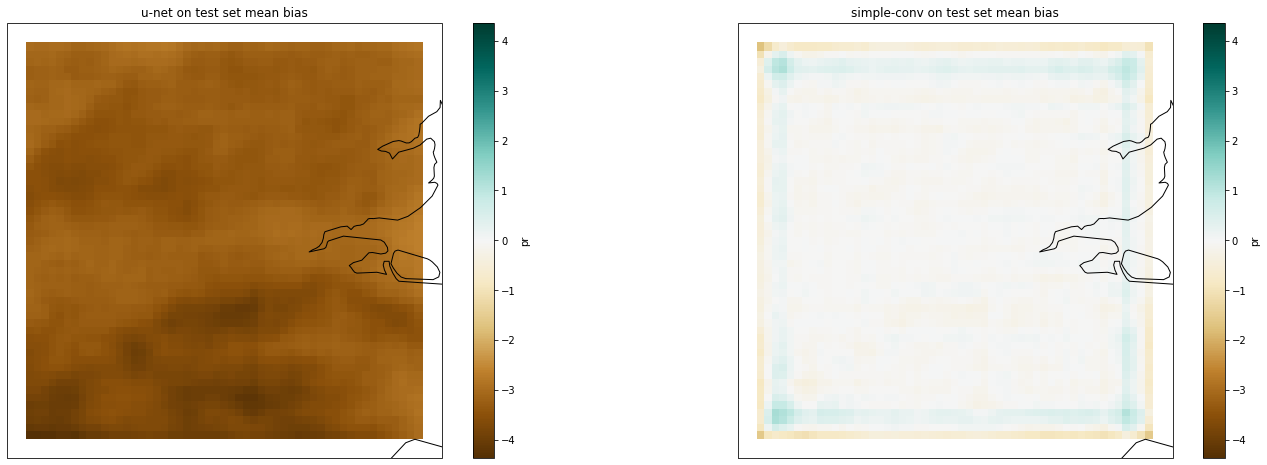

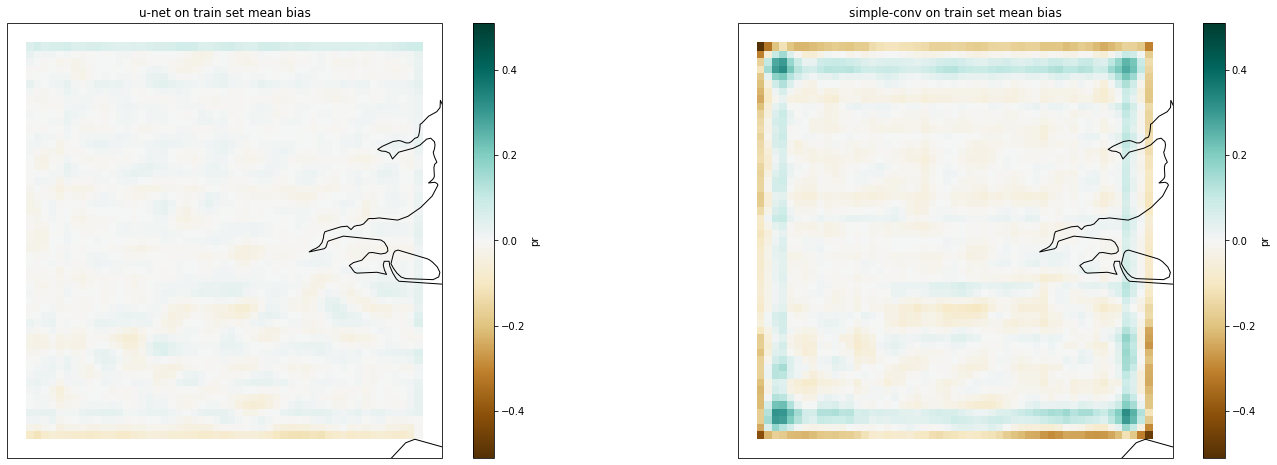

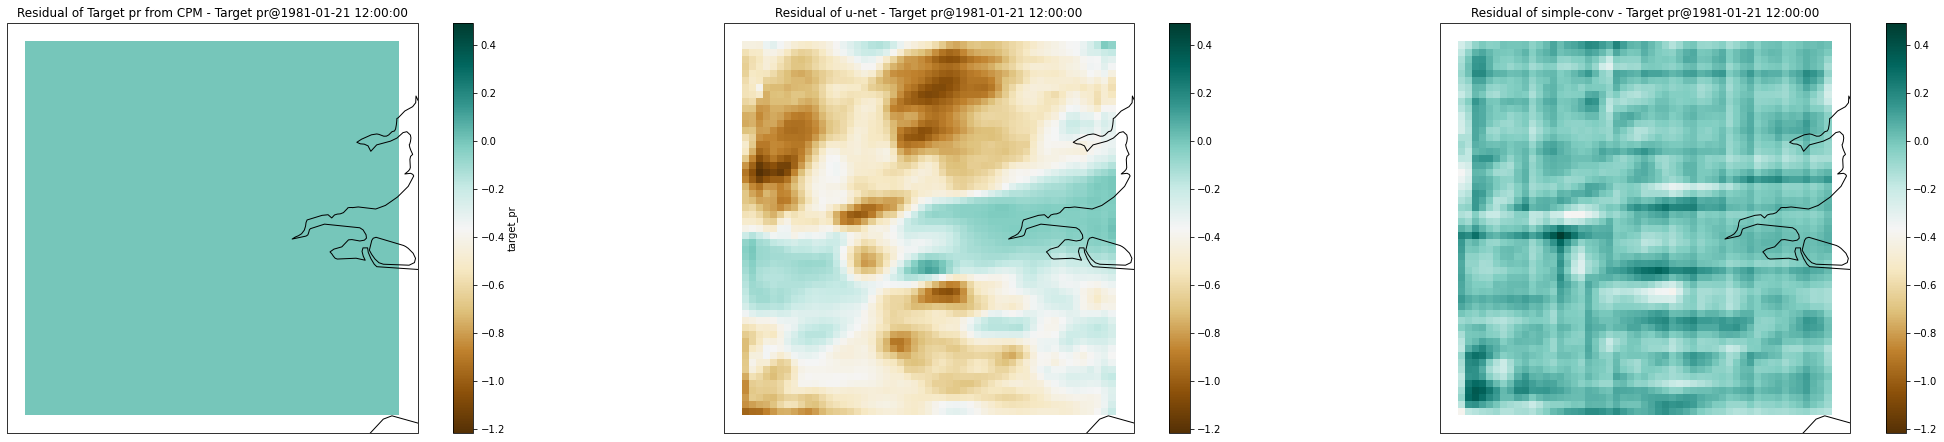

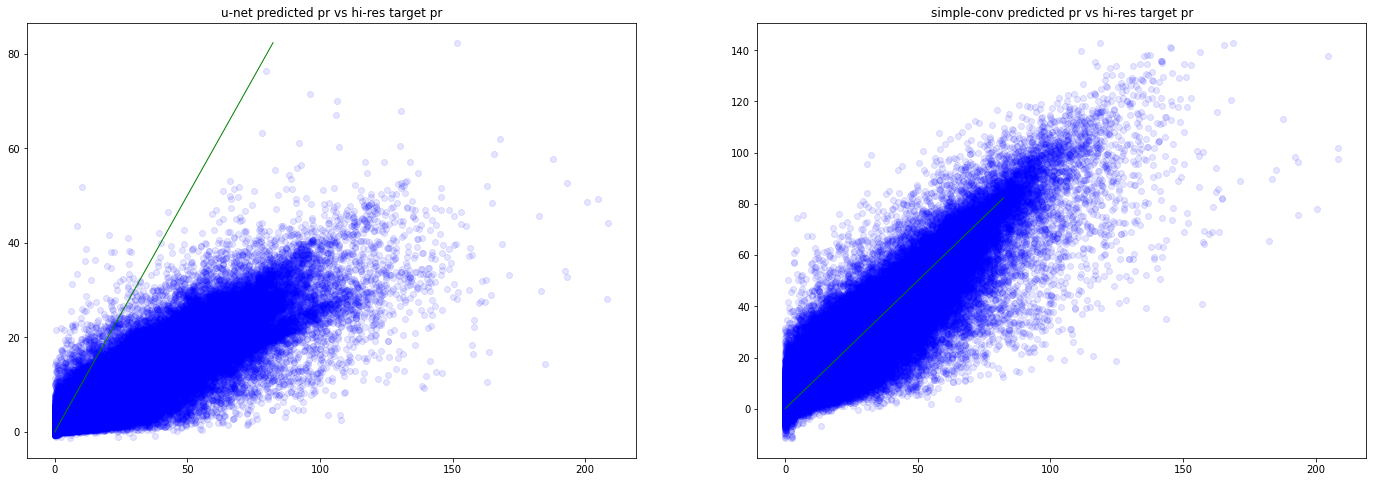

In [21]:
sf = 4
compare_preds([data["pred"][arch][sf] for arch in model_archs], [data["bias"][arch][sf] for arch in model_archs], test_sets[sf], model_archs)

## 8x coarsened

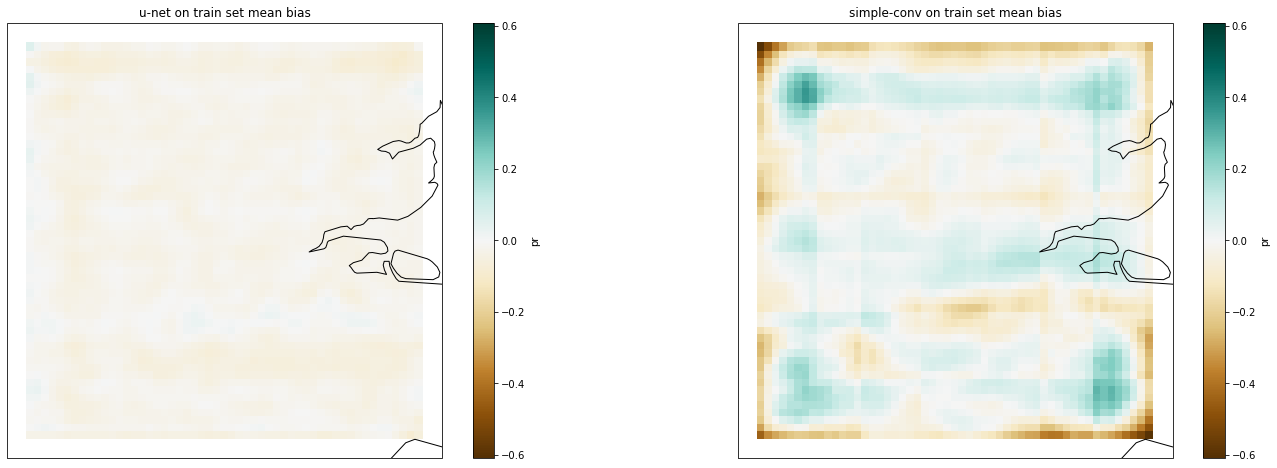

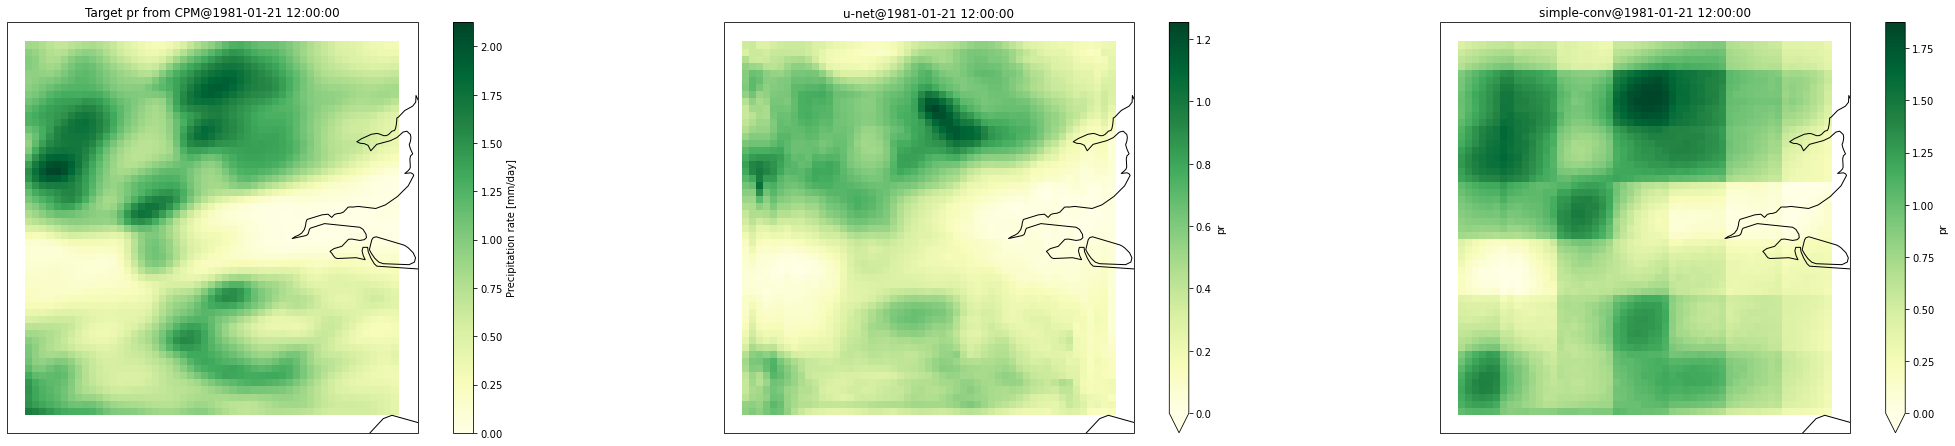

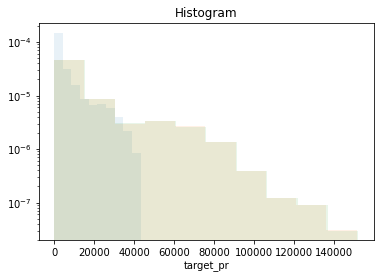

In [22]:
sf = 8
compare_preds([data["pred"][arch][sf] for arch in model_archs], [data["bias"][arch][sf] for arch in model_archs], test_sets[sf], model_archs)

## 16x coarsened

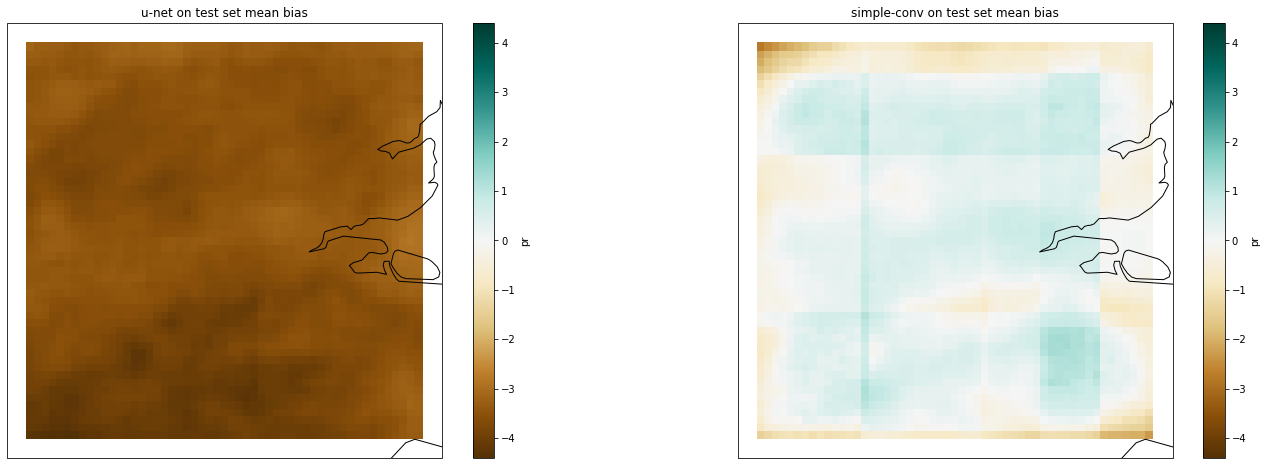

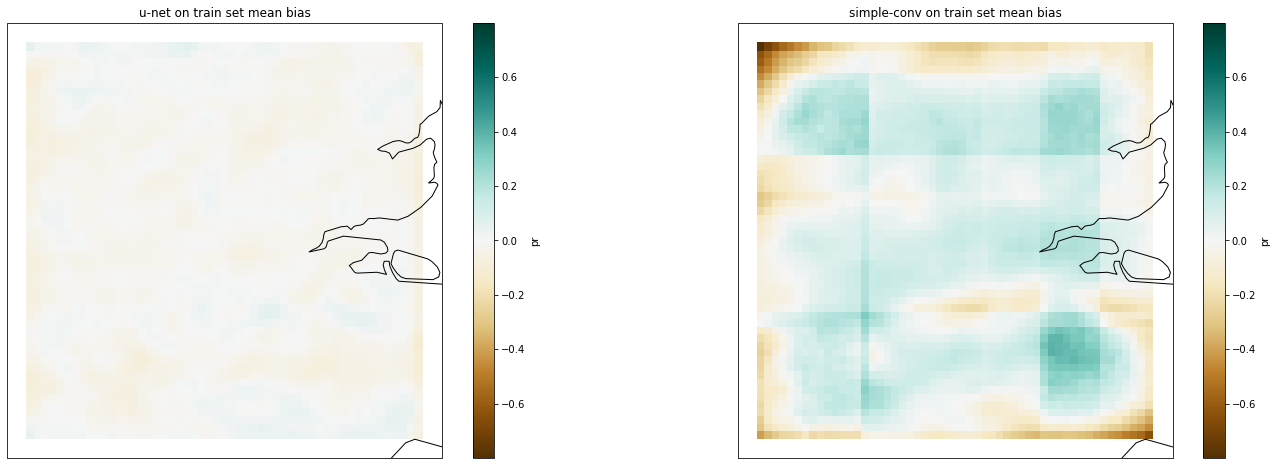

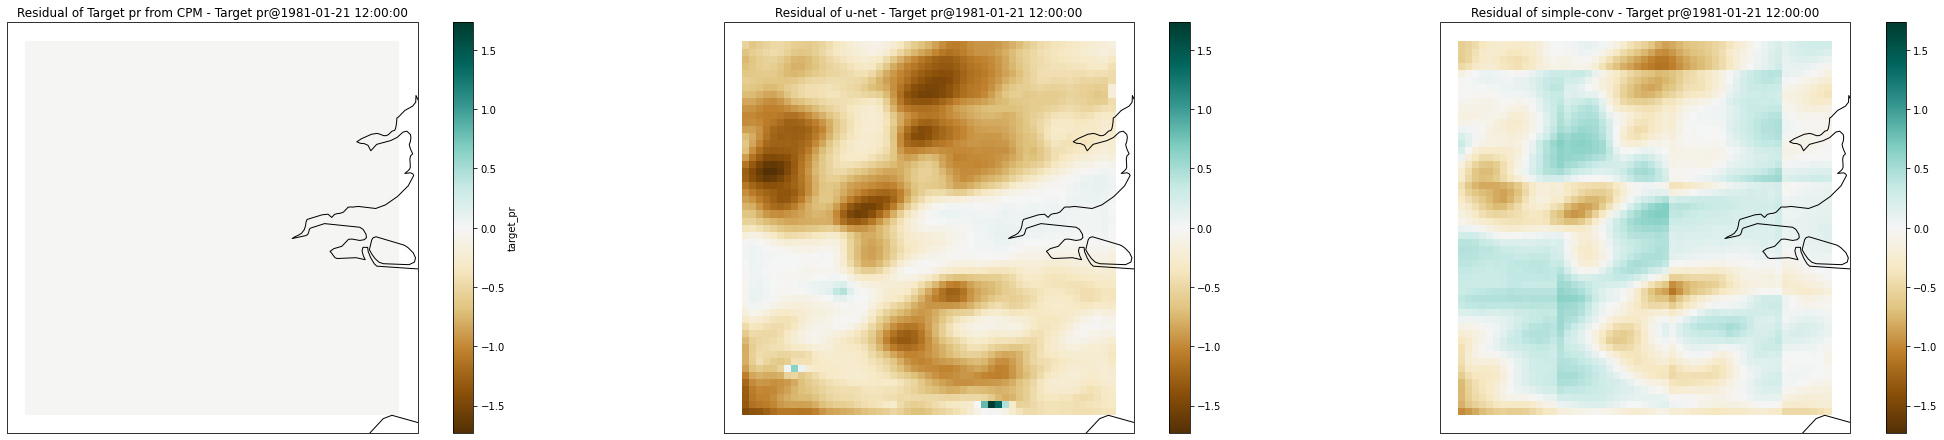

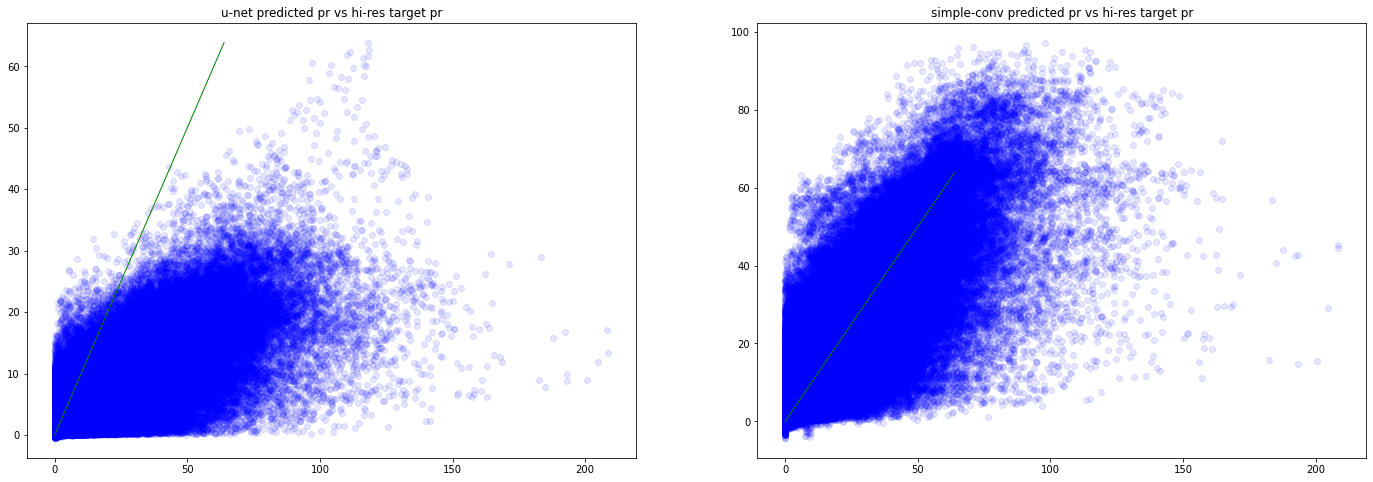

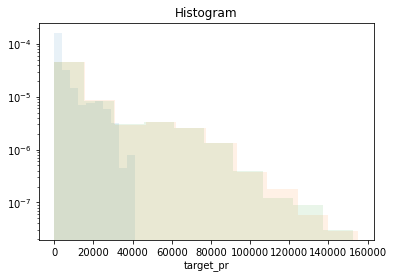

In [23]:
sf = 16
compare_preds([data["pred"][arch][sf] for arch in model_archs], [data["bias"][arch][sf] for arch in model_archs], test_sets[sf], model_archs)

## 27x coarsened (~GCM resolution)

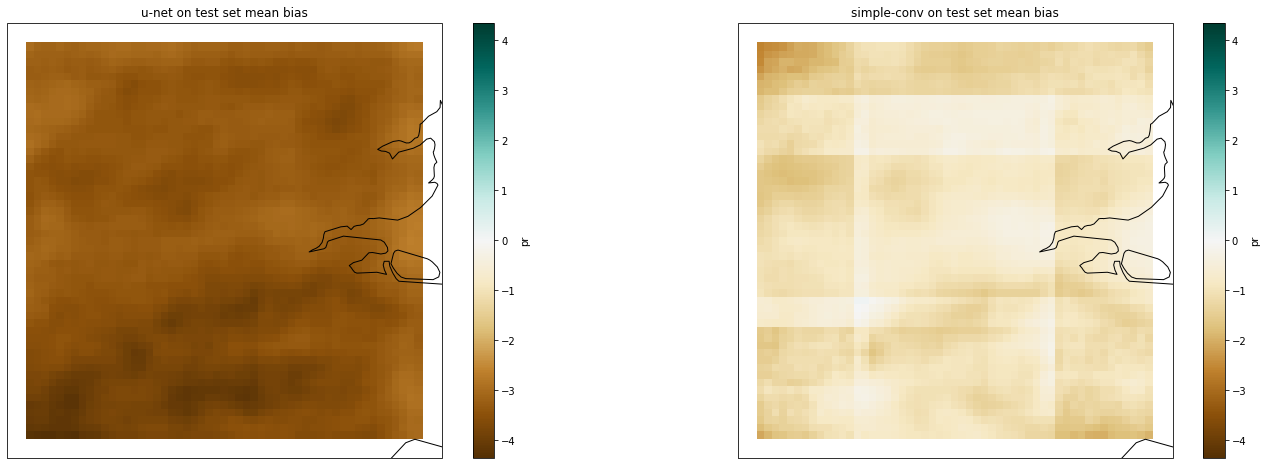

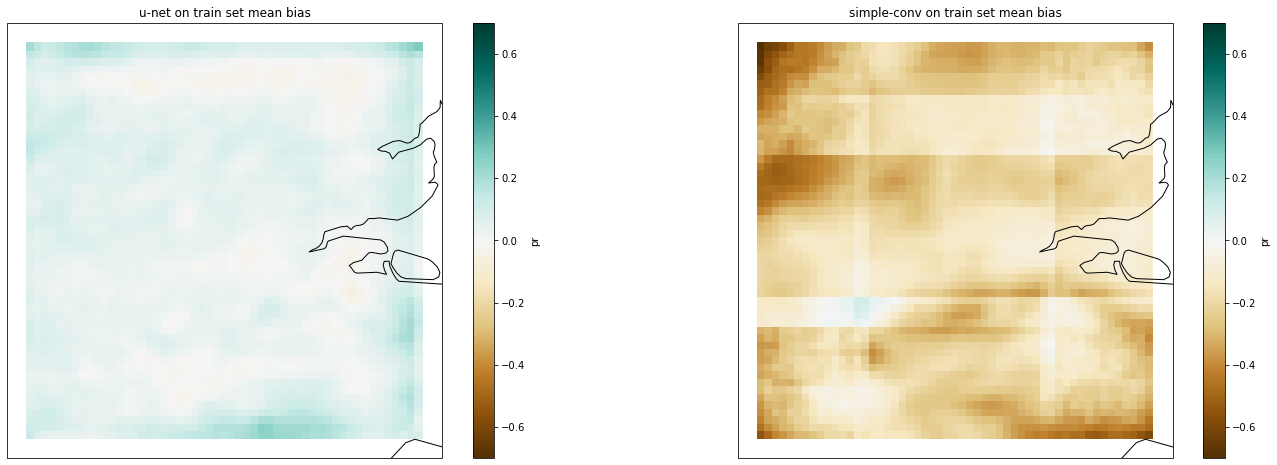

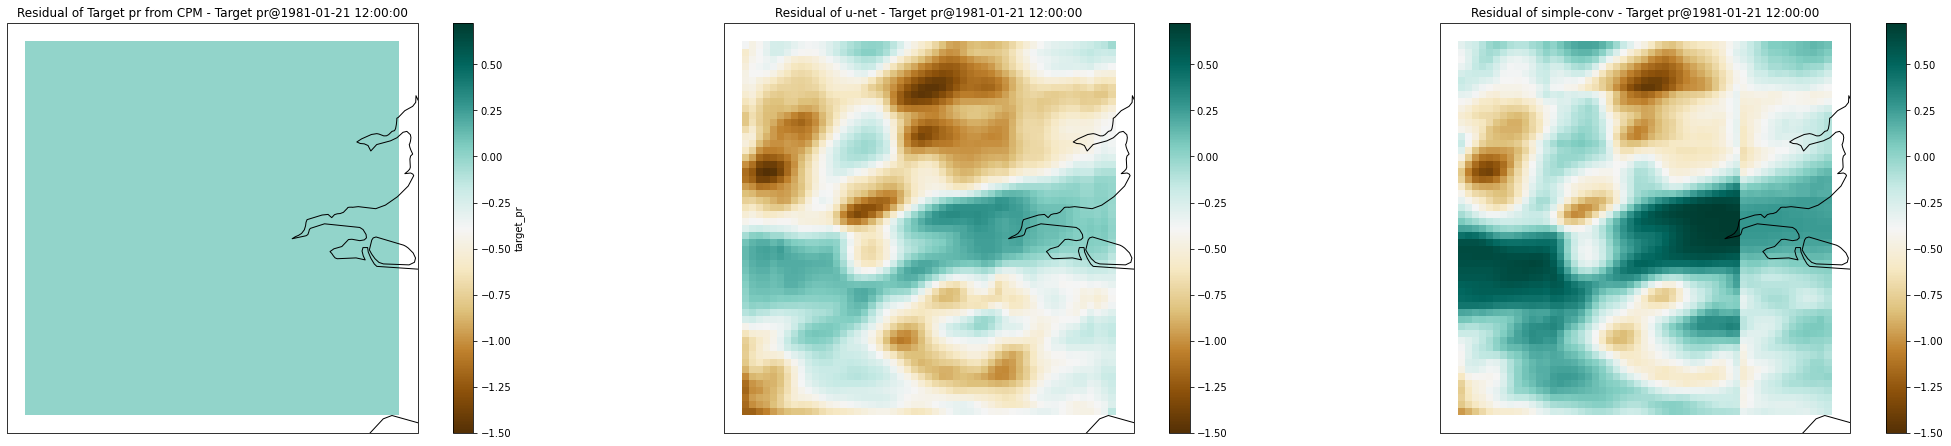

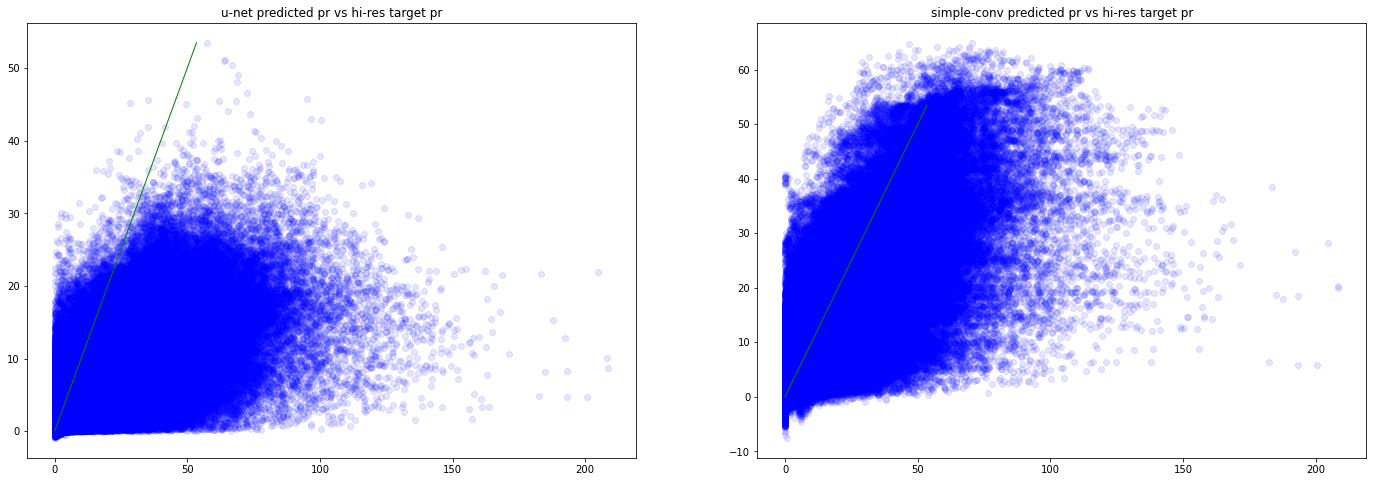

In [24]:
sf = 27
compare_preds([data["pred"][arch][sf] for arch in model_archs], [data["bias"][arch][sf] for arch in model_archs], test_sets[sf], model_archs)

## Comparing U-Nets with different coarsening scale factors

Plotted below are the U-Net predictions for the 5 different scale factors and beneath them the corresponding coarsened input and below that the residuals. The first column is the target precipitation of the full-resolution CPM output.

There are three rows for 10 randomly selected timestamps from the test set.

In [25]:
rng = np.random.default_rng(seed=42)
timestamps = rng.choice(test_sets[2].time, 10)
timestamps = np.append(timestamps, test_sets[2].time[0])

unet_datasets = [test_sets[2].target_pr]+[data["pred"]["u-net"][sf]['pr'] for sf in scale_factors]
input_datasets = [test_sets[2].target_pr]+[test_sets[sf]['pr'] for sf in scale_factors]
residual_datasets = [test_sets[2].target_pr - test_sets[2].target_pr] + [test_sets[sf].target_pr - data["pred"]["u-net"][sf]['pr'] for sf in scale_factors]

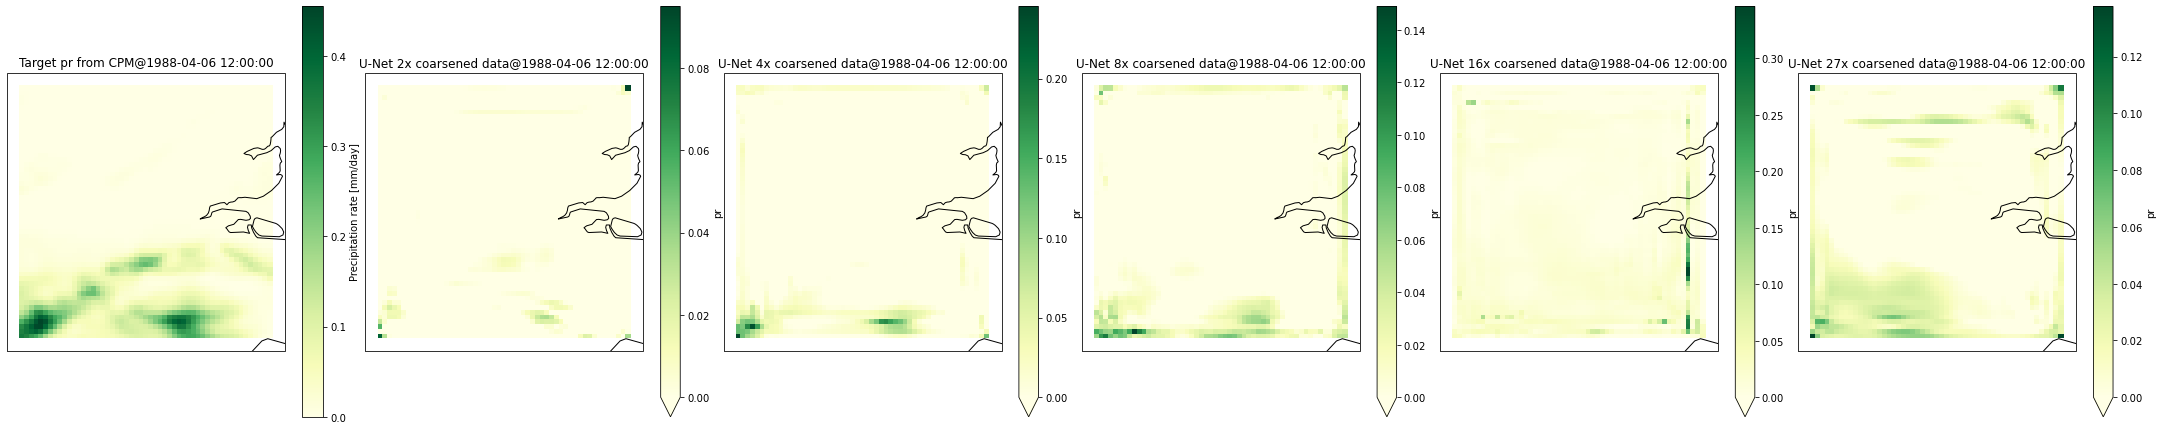

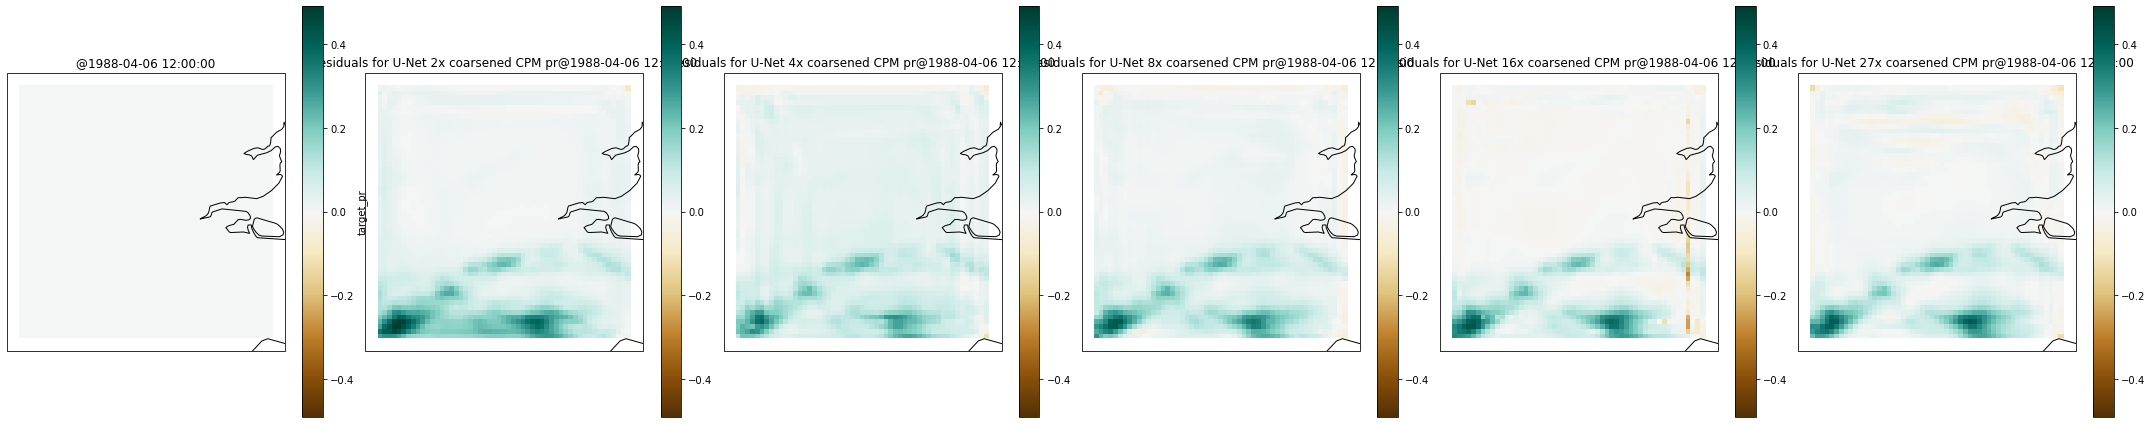

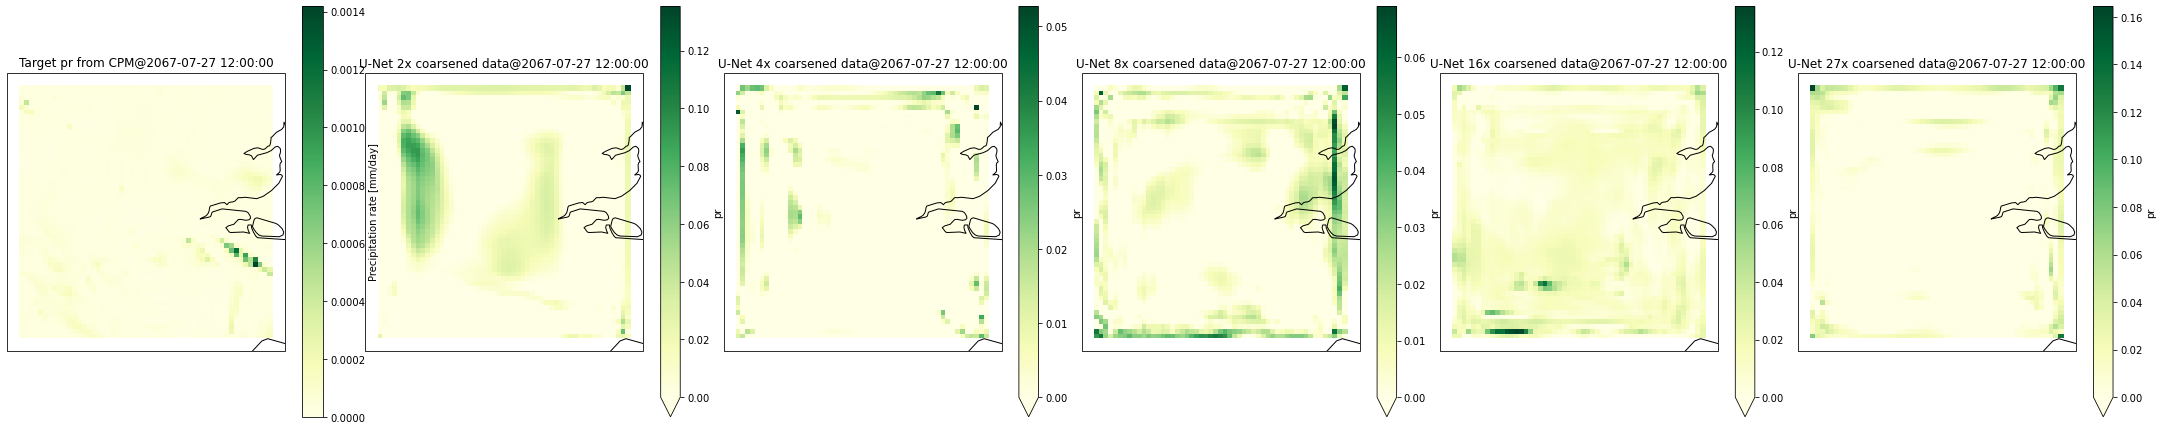

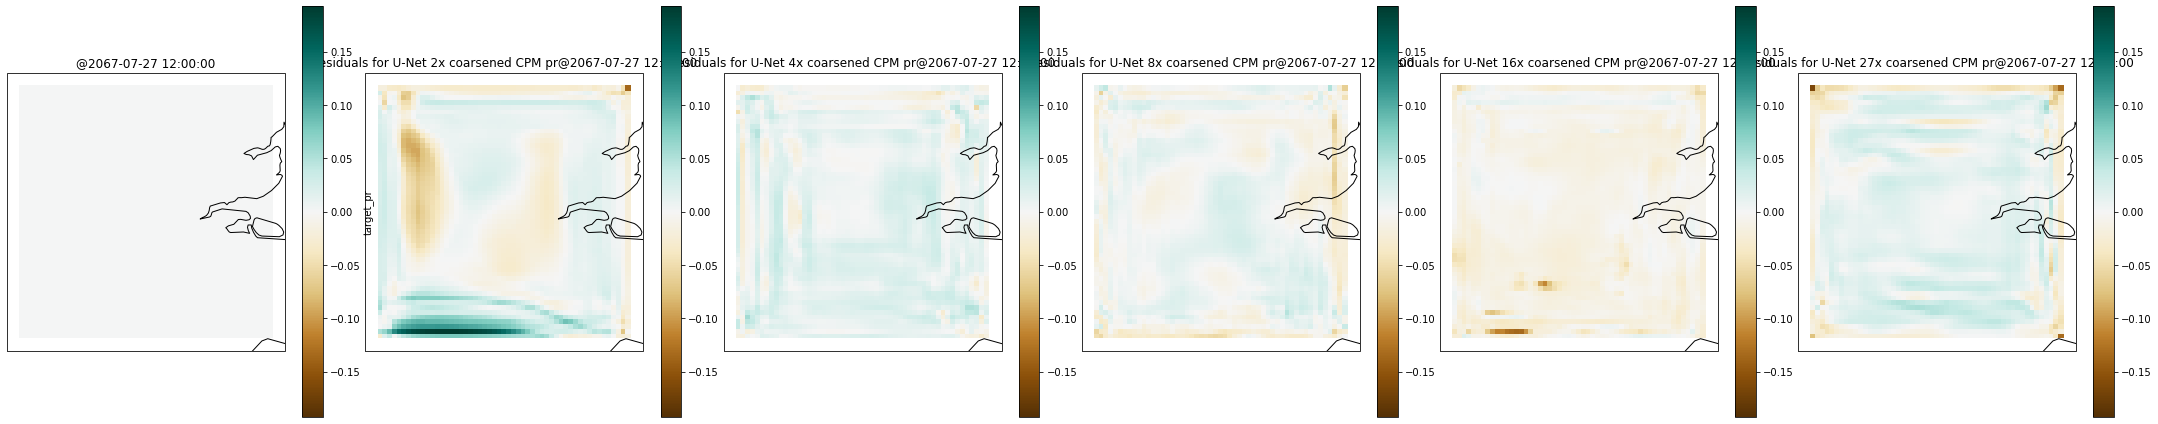

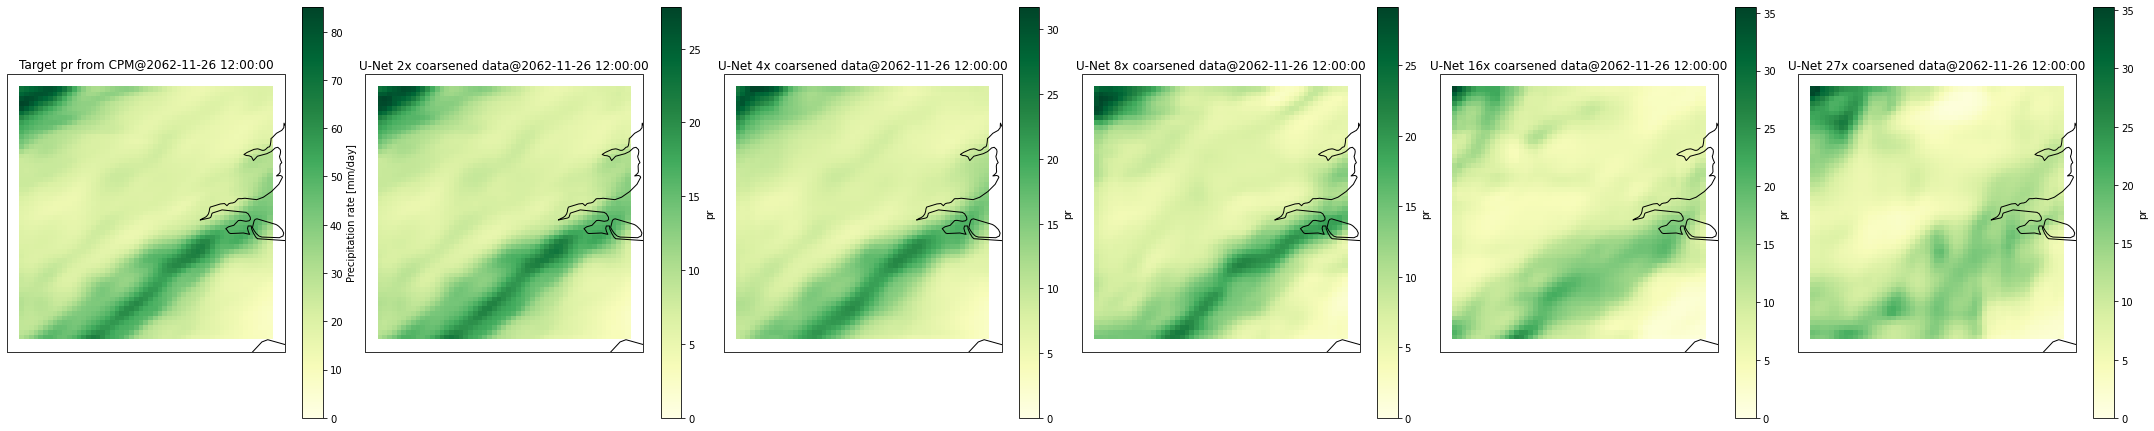

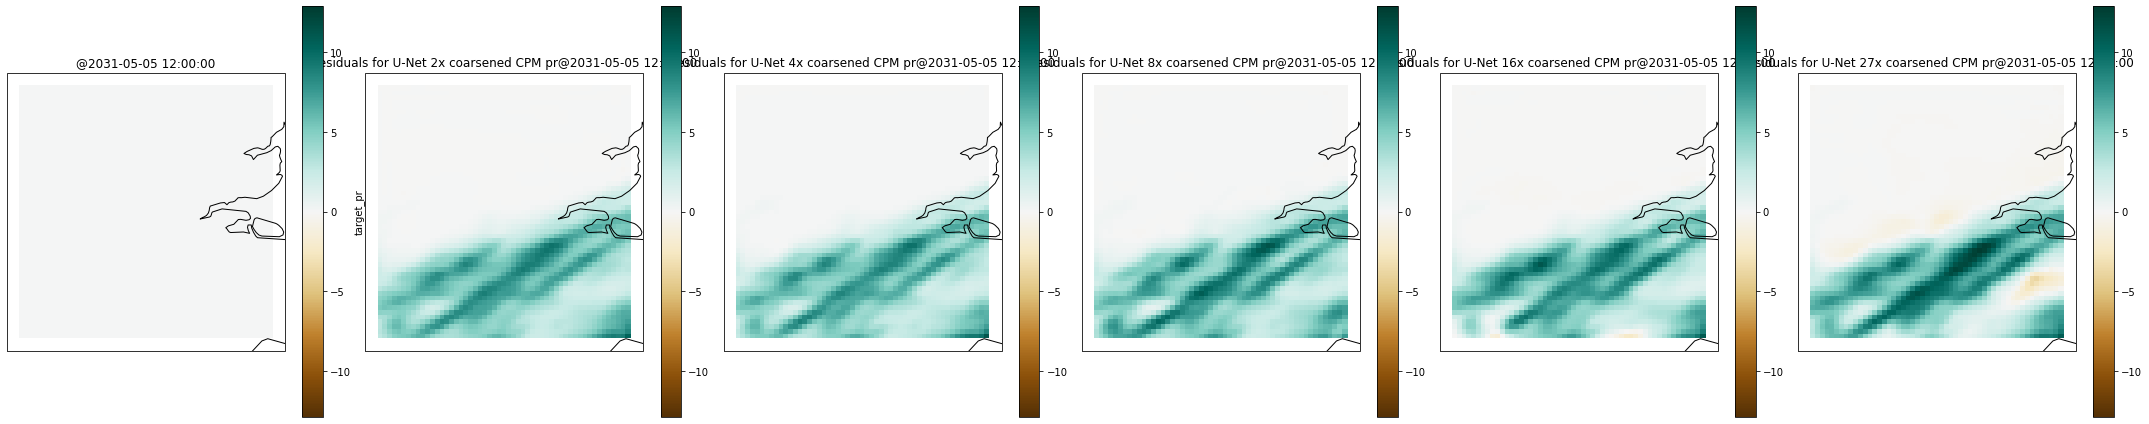

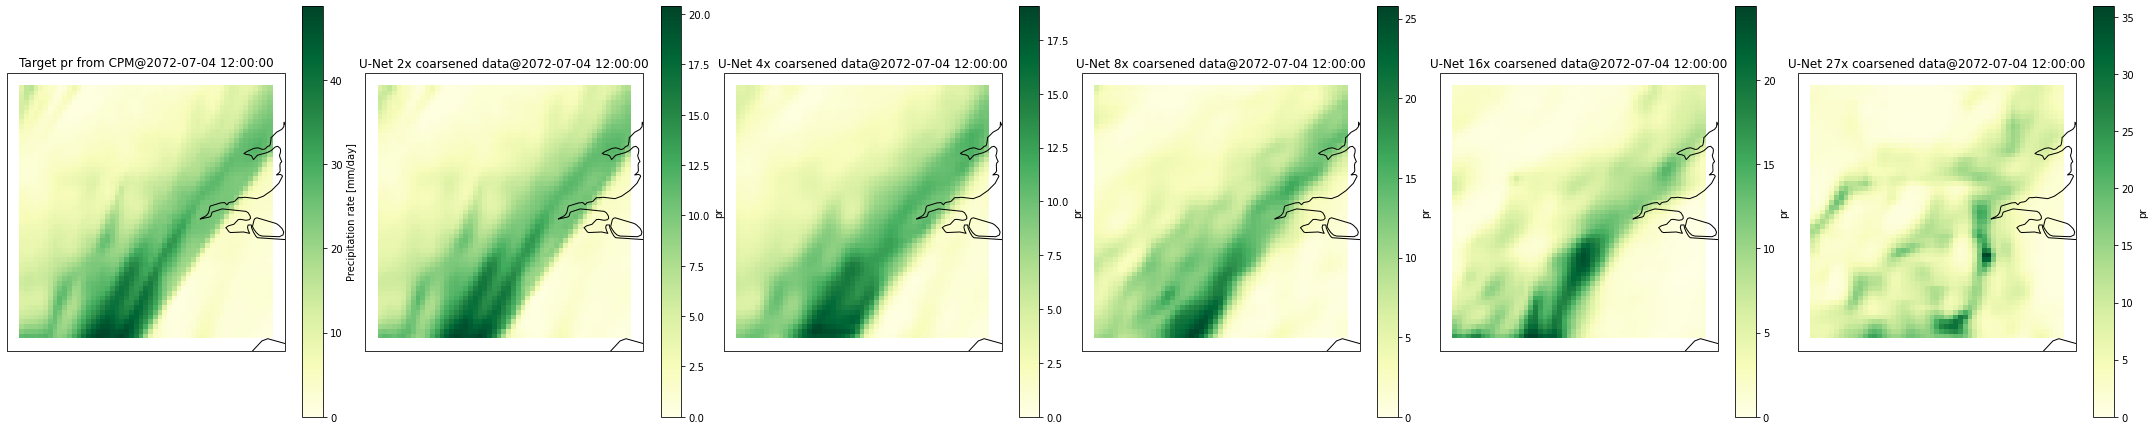

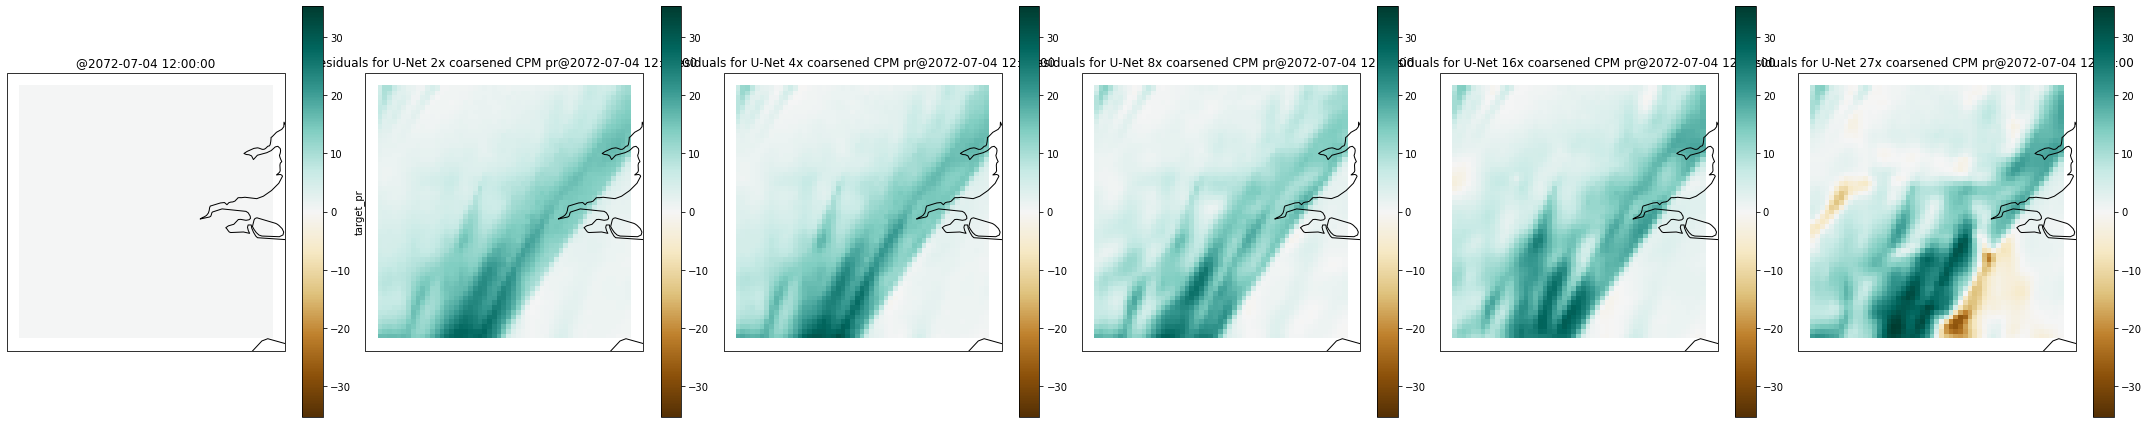

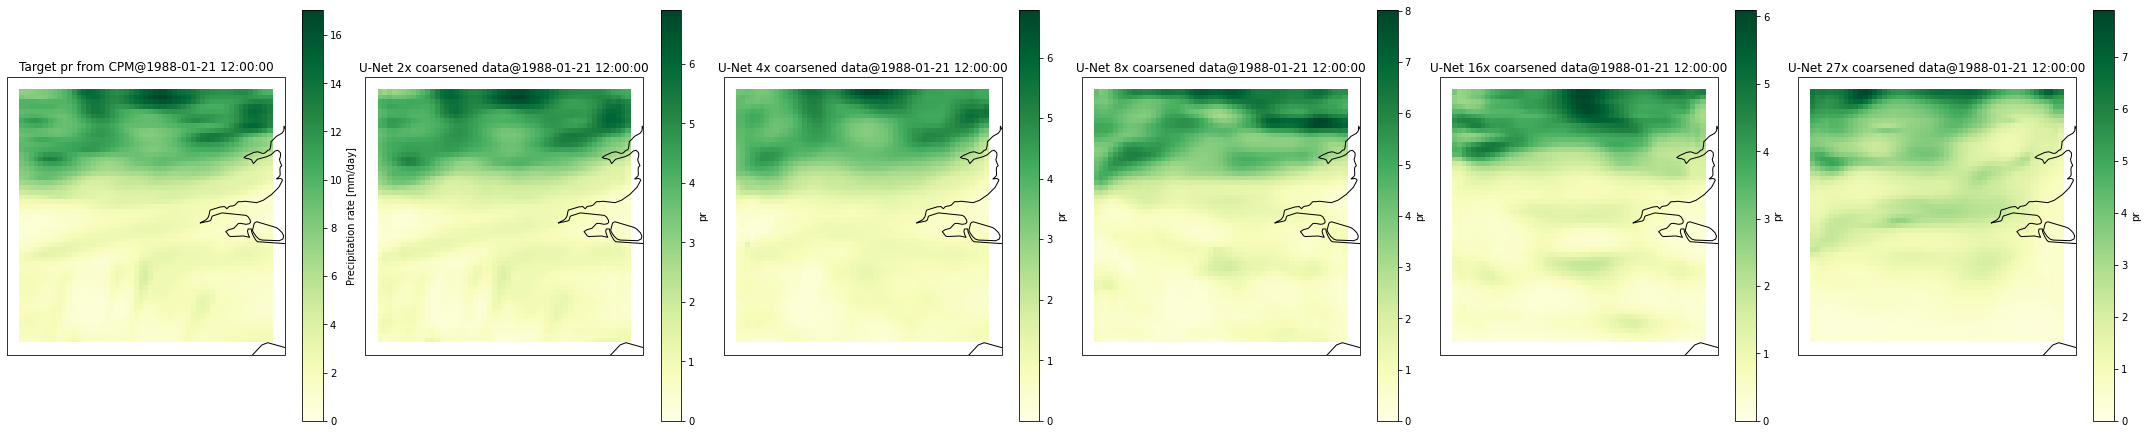

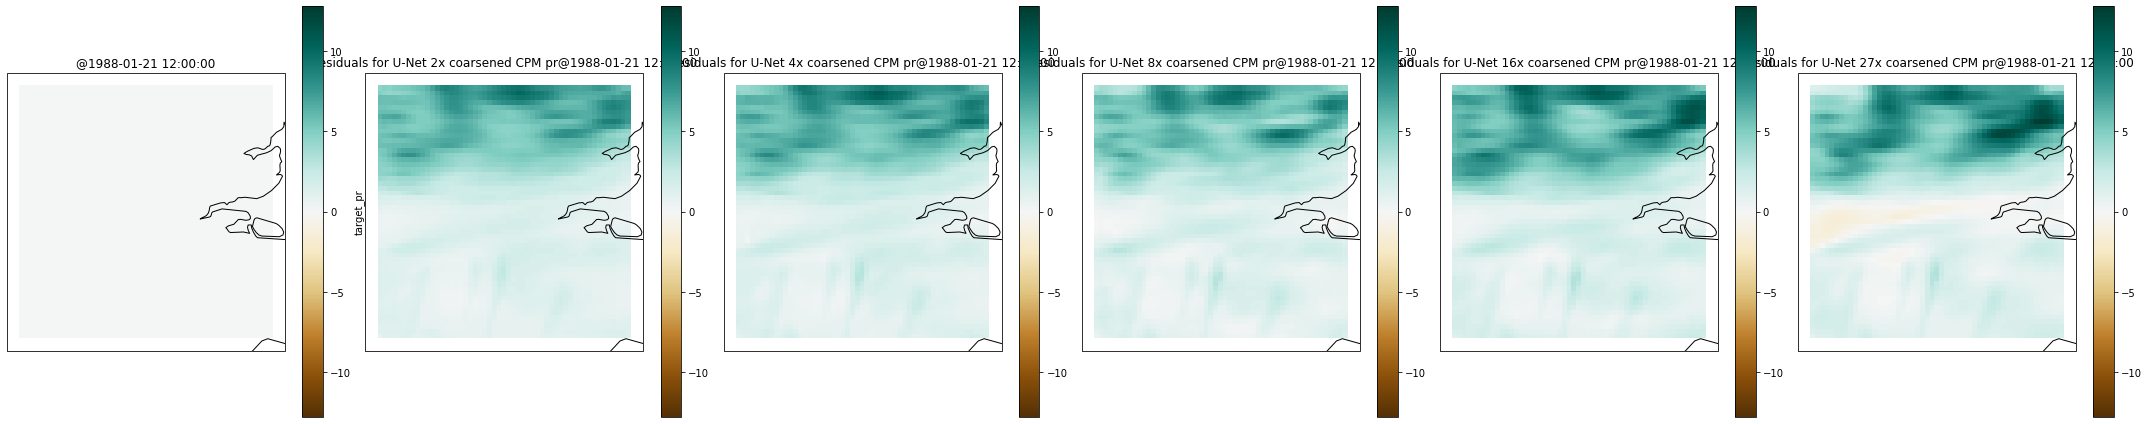

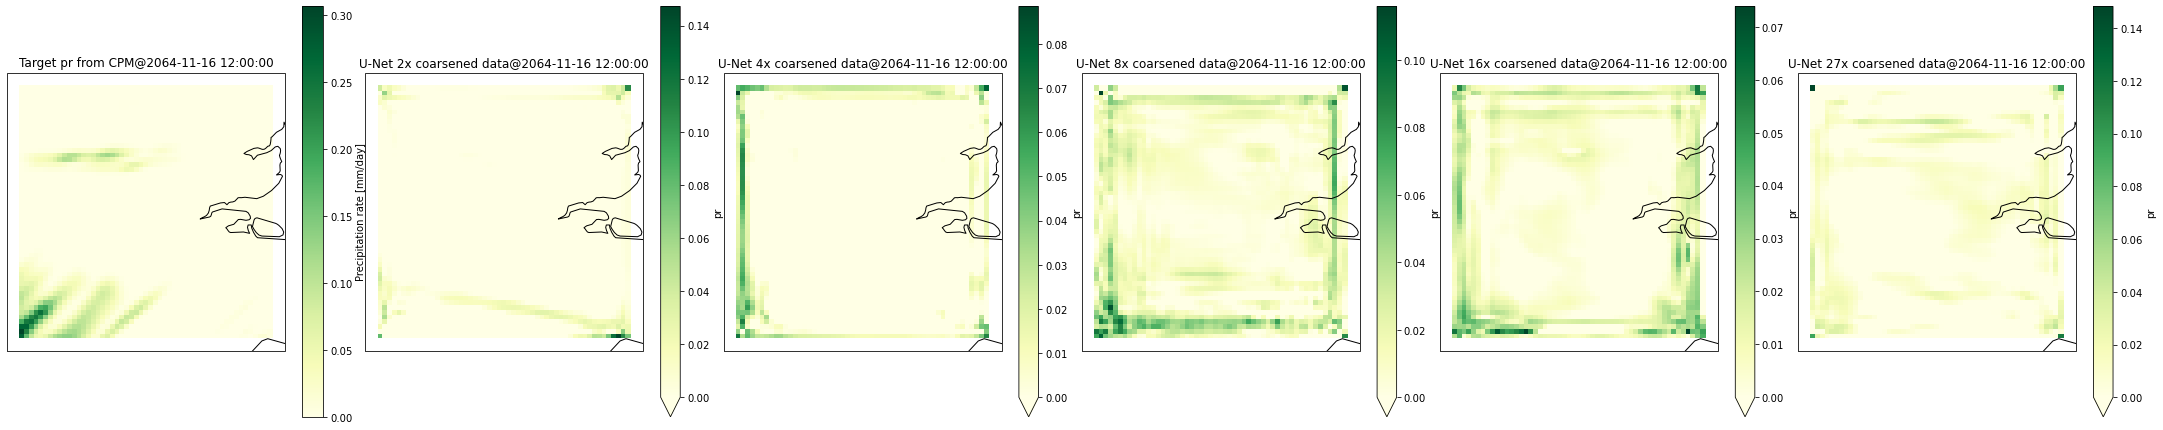

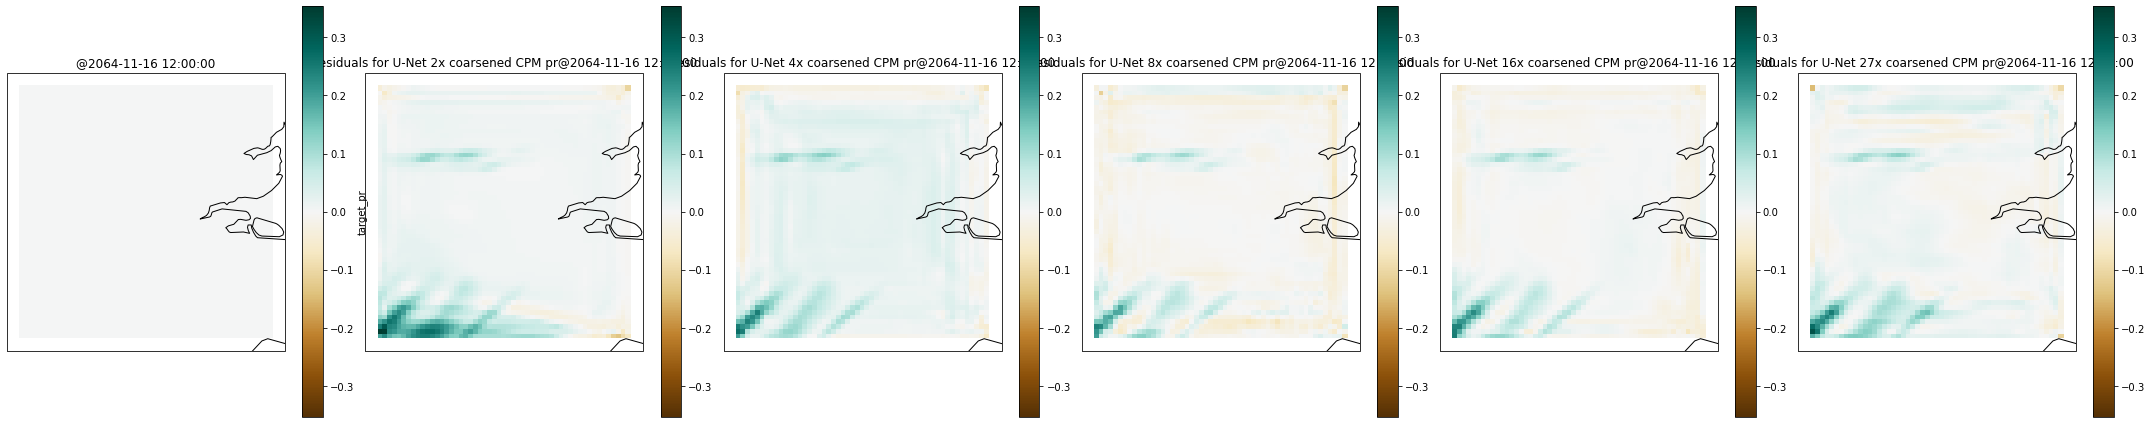

In [26]:
vmax = None#45 # max(*[ds.max().values for ds in unet_datasets+input_datasets])
import matplotlib.pyplot as plt
for timestamp in timestamps:
    plots_at_ts(unet_datasets, timestamp, titles=["Target pr from CPM"]+[f"U-Net {sf}x coarsened data" for sf in scale_factors], vmax=vmax)
#     plots_at_ts(input_datasets, timestamp, titles=["Target pr from CPM"]+[f"{sf}x coarsened CPM pr" for sf in scale_factors], vmax=vmax, cmap='Greens')
    res_vmin = min([ds.sel(time=timestamp).min().values for ds in residual_datasets])
    res_vmax = max([ds.sel(time=timestamp).max().values for ds in residual_datasets])
    res_vmin = min(res_vmin, -res_vmax)
    res_vmax = max(-res_vmin, res_vmax)
    plots_at_ts(residual_datasets, timestamp, titles= [""]+[f"Residuals for U-Net {sf}x coarsened CPM pr" for sf in scale_factors], vmin=res_vmin, vmax=res_vmax, cmap="BrBG")
    plt.show()